# Toxic Comment Analysis with CNN & LDA

## 1. Reading data

In [1]:
TRAIN_FP = 'train.csv'
TEST_FP = 'test.csv'
MAX_NUM_WORDS = 10000

import keras
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

#set gpu config
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print 'Using 1 GPU and 4 cores of CPU'

#read data
print 'loading data...'
train_data, test_data = pd.read_csv('train.csv'), pd.read_csv('test.csv')
texts = train_data.values[:,1]
labels = train_data.values[:,2:]
print 'loading complete!'

Using TensorFlow backend.


Using 1 GPU and 4 cores of CPU
loading data...
loading complete!


## 2. Tokenizing

In [2]:
print 'Tokenizing text and turing them into sequences...'
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
#sequences is a array of number[123, 456, 12 ...]
print 'process complete!'

#word index is the dictionary of sequences
word_index = tokenizer.word_index
print 'pading sequences...'
MAX_SEQUENCE_LENGTH = 200
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print 'padding complete!'

Tokenizing text and turing them into sequences...
process complete!
pading sequences...
padding complete!


## 3. shuffling data and split for Cross-Validation

In [3]:
from keras.utils import to_categorical
#turn the labels into categotical
label = dict()
for i in range(labels.shape[1]):  
    label[str(i)] = to_categorical(np.asarray(labels[:,i]))
    
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
for i in range(labels.shape[1]): 
    label[str(i)] = label[str(i)][indices]
#shuffle the data
VALIDATION_SPLIT = 0.2
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

## 4. Read GloVe pre-trained embedding and implement embedding matrix

In [4]:
import os
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, 'glove')
#read pre-trained word embedding and turn them into a dictionary call embedding_index
print 'reading pre-trained word embedding...'
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print 'reading complete!' 
#
print 'making embedding matrix..'
EMBEDDING_DIM = 300
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print 'process complete!'

reading pre-trained word embedding...
reading complete!
making embedding matrix..
process complete!


In [24]:
from keras.models import load_model
model = load_model('model_label1.h5')
model.layers[7].output

<tf.Tensor 'global_max_pooling1d_3_10/Max:0' shape=(?, 128) dtype=float32>

## 5. Using CNN to train for each label

In [5]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='sigmoid')(x)

x_train = data[:-num_validation_samples]
#y_train = label['0'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
#y_val = label['0'][-num_validation_samples:]

### I. First Label

In [23]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['0'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['0'][-num_validation_samples:]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

model.save('model_label1.h5')
del model  
#model = load_model('my_model.h5')

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127657/127657 [==============================] - 15s - loss: 0.2000 - acc: 0.9294 - val_loss: 0.1539 - val_acc: 0.9471
Epoch 2/10
127657/127657 [==============================] - 14s - loss: 0.1423 - acc: 0.9503 - val_loss: 0.1492 - val_acc: 0.9497
Epoch 3/10
127657/127657 [==============================] - 14s - loss: 0.1251 - acc: 0.9560 - val_loss: 0.1577 - val_acc: 0.9515
Epoch 4/10
127657/127657 [==============================] - 14s - loss: 0.1137 - acc: 0.9606 - val_loss: 0.1674 - val_acc: 0.9524
Epoch 5/10
127657/127657 [==============================] - 14s - loss: 0.0979 - acc: 0.9663 - val_loss: 0.2205 - val_acc: 0.9470
Epoch 6/10
127657/127657 [==============================] - 14s - loss: 0.0858 - acc: 0.9707 - val_loss: 0.1843 - val_acc: 0.9421
Epoch 7/10
127657/127657 [==============================] - 13s - loss: 0.0755 - acc: 0.9751 - val_loss: 0.2659 - val_acc: 0.9403
Epoch 8/10
127657/127657 [=============

### II. Second Label

In [24]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['1'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['1'][-num_validation_samples:]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

model.save('model_label2.h5')
del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127657/127657 [==============================] - 14s - loss: 0.0427 - acc: 0.9902 - val_loss: 0.0527 - val_acc: 0.9891
Epoch 2/10
127657/127657 [==============================] - 13s - loss: 0.0356 - acc: 0.9907 - val_loss: 0.0705 - val_acc: 0.9896
Epoch 3/10
127657/127657 [==============================] - 13s - loss: 0.0336 - acc: 0.9912 - val_loss: 0.0580 - val_acc: 0.9895
Epoch 4/10
127657/127657 [==============================] - 13s - loss: 0.0335 - acc: 0.9919 - val_loss: 0.0646 - val_acc: 0.9893
Epoch 5/10
127657/127657 [==============================] - 14s - loss: 0.0310 - acc: 0.9924 - val_loss: 0.0815 - val_acc: 0.9893
Epoch 6/10
127657/127657 [==============================] - 14s - loss: 0.0325 - acc: 0.9932 - val_loss: 0.0766 - val_acc: 0.9890
Epoch 7/10
127657/127657 [==============================] - 14s - loss: 0.0323 - acc: 0.9940 - val_loss: 0.0971 - val_acc: 0.9877
Epoch 8/10
127657/127657 [=============

### III. Third Label

In [25]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['2'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['2'][-num_validation_samples:]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

model.save('model_label3.h5')
del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127657/127657 [==============================] - 14s - loss: 0.2004 - acc: 0.9668 - val_loss: 0.1186 - val_acc: 0.9711
Epoch 2/10
127657/127657 [==============================] - 13s - loss: 0.1065 - acc: 0.9729 - val_loss: 0.1776 - val_acc: 0.9686
Epoch 3/10
127657/127657 [==============================] - 13s - loss: 0.0963 - acc: 0.9757 - val_loss: 0.1302 - val_acc: 0.9720
Epoch 4/10
127657/127657 [==============================] - 13s - loss: 0.0897 - acc: 0.9776 - val_loss: 0.1693 - val_acc: 0.9498
Epoch 5/10
127657/127657 [==============================] - 13s - loss: 0.0828 - acc: 0.9803 - val_loss: 0.1738 - val_acc: 0.9718
Epoch 6/10
127657/127657 [==============================] - 13s - loss: 0.0764 - acc: 0.9822 - val_loss: 0.1905 - val_acc: 0.9619
Epoch 7/10
127657/127657 [==============================] - 13s - loss: 0.0704 - acc: 0.9846 - val_loss: 0.1801 - val_acc: 0.9610
Epoch 8/10
127657/127657 [=============

### IV. Fourth Label

In [26]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['3'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['3'][-num_validation_samples:]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

model.save('model_label4.h5')
del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127657/127657 [==============================] - 15s - loss: 0.0501 - acc: 0.9967 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 2/10
127657/127657 [==============================] - 15s - loss: 0.0496 - acc: 0.9969 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 3/10
127657/127657 [==============================] - 14s - loss: 0.0496 - acc: 0.9969 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 4/10
127657/127657 [==============================] - 14s - loss: 0.0496 - acc: 0.9969 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 5/10
127657/127657 [==============================] - 14s - loss: 0.0496 - acc: 0.9969 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 6/10
127657/127657 [==============================] - 14s - loss: 0.0496 - acc: 0.9969 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 7/10
127657/127657 [==============================] - 14s - loss: 0.0496 - acc: 0.9969 - val_loss: 0.0417 - val_acc: 0.9974
Epoch 8/10
127657/127657 [=============

### V. Fifth Label

In [27]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['4'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['4'][-num_validation_samples:]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))


model.save('model_label5.h5')
del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 2/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 3/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 4/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 5/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 6/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 7/10
127657/127657 [==============================] - 14s - loss: 0.7887 - acc: 0.9508 - val_loss: 0.8017 - val_acc: 0.9500
Epoch 8/10
127657/127657 [=============

### VI. Sixth Label

In [28]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]

model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_val, y_val))

model.save('model_label6.h5')
del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 2/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 3/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 4/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 5/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 6/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 7/10
127657/127657 [==============================] - 14s - loss: 0.1432 - acc: 0.9911 - val_loss: 0.1331 - val_acc: 0.9917
Epoch 8/10
127657/127657 [=============

### VII. Caculating overall accuracy 

In [32]:
from keras.models import load_model

y_pred = dict()
for i in range(labels.shape[1]):
    model = load_model('model_label'+str(i+1)+'.h5')
    y_pred[str(i)] = model.predict(x_val, batch_size = 128, verbose = 1)

31744/31914 [============================>.] - ETA: 0s

In [46]:
from sklearn.metrics import roc_auc_score
roc_pred = np.vstack((y_pred['0'][:,1], y_pred['1'][:,1], y_pred['2'][:,1], y_pred['3'][:,1], y_pred['4'][:,1], \
                     y_pred['5'][:,1])).reshape(-1,6)

yt = labels[indices][:-num_validation_samples]
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

print 'roc score for CNN is:',roc_auc_score(yv, roc_pred)

roc score for CNN is: 0.502107517048


In [47]:
import numpy as np

for i in range(6):
    for j in range(y_pred['0'].shape[0]):
        if y_pred[str(i)][j,0] > y_pred[str(i)][j,1]:
            y_pred[str(i)][j,:] = np.array([1,0]).reshape((1,2))
        else:
            y_pred[str(i)][j,:] = np.array([0,1]).reshape((1,2))




def compute_acc(y_pred, y_val):
    num_samples = y_pred['0'].shape[0]
    num_correct = 0
    for i in range(num_samples):
        if np.array_equal(y_pred['0'][i,:], label['0'][i,:]) and np.array_equal(y_pred['1'][i,:], label['1'][i,:]) and \
        np.array_equal(y_pred['2'][i,:], label['2'][i,:]) and np.array_equal(y_pred['3'][i,:], label['3'][i,:]) and \
        np.array_equal(y_pred['4'][i,:], label['4'][i,:]) and np.array_equal(y_pred['5'][i,:], label['5'][i,:]):
            num_correct = num_correct + 1
    return float(num_correct)/float(num_samples)
print 'accuracy:',compute_acc(y_pred, label)

accuracy: 0.819326941154


## 6. Vanila CNN for all label

In [11]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
#x = Dropout(0.2)(embedded_sequences)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = labels[indices][:-num_validation_samples]
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)

#for i in range(1,10):
model.fit(x_train, yt,
          batch_size=128,
          epochs=10,
          callbacks = [ra],
          validation_data=(x_val, yv))

from keras.models import load_model

model.save('model_alllabel.h5')
#del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9672
 ROC-AUC - epoch: 1 - score: 0.932962
127657/127657 [==============================] - 17s - loss: 0.1014 - acc: 0.9672 - val_loss: 0.0834 - val_acc: 0.9722
Epoch 2/10
127360/127657 [============================>.] - ETA: 0s - loss: 0.0791 - acc: 0.9727
 ROC-AUC - epoch: 2 - score: 0.942005
127657/127657 [==============================] - 17s - loss: 0.0791 - acc: 0.9727 - val_loss: 0.0788 - val_acc: 0.9727
Epoch 3/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0694 - acc: 0.9756
 ROC-AUC - epoch: 3 - score: 0.956951
127657/127657 [==============================] - 17s - loss: 0.0694 - acc: 0.9756 - val_loss: 0.0653 - val_acc: 0.9775
Epoch 4/10
127360/127657 [============================>.] - ETA: 0s - loss: 0.0560 - acc: 0.9800
 ROC-AUC - epoch: 4 - score: 0.960213
127657/127657 [==============================] - 17s

## CNN with 0.2 Dropout

In [48]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
#x = Dropout(0.2)(embedded_sequences)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = labels[indices][:-num_validation_samples]
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)

#for i in range(1,10):
model.fit(x_train, yt,
          batch_size=128,
          epochs=10,
          callbacks = [ra],
          validation_data=(x_val, yv))

#model.save('model_alllabel.h5')
#del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127232/127657 [============================>.] - ETA: 0s - loss: 0.0974 - acc: 0.9687
 ROC-AUC - epoch: 1 - score: 0.952840
127657/127657 [==============================] - 18s - loss: 0.0973 - acc: 0.9688 - val_loss: 0.0649 - val_acc: 0.9773
Epoch 2/10
127360/127657 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9781
 ROC-AUC - epoch: 2 - score: 0.961677
127657/127657 [==============================] - 17s - loss: 0.0637 - acc: 0.9781 - val_loss: 0.0602 - val_acc: 0.9789
Epoch 3/10
127488/127657 [============================>.] - ETA: 0s - loss: 0.0581 - acc: 0.9796
 ROC-AUC - epoch: 3 - score: 0.962536
127657/127657 [==============================] - 17s - loss: 0.0581 - acc: 0.9796 - val_loss: 0.0605 - val_acc: 0.9790
Epoch 4/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9807
 ROC-AUC - epoch: 4 - score: 0.961976
127657/127657 [==============================] - 17s

## CNN with 0.5 Dropout

In [49]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
#x = Dropout(0.2)(embedded_sequences)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = labels[indices][:-num_validation_samples]
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)

#for i in range(1,10):
model.fit(x_train, yt,
          batch_size=128,
          epochs=10,
          callbacks = [ra],
          validation_data=(x_val, yv))

#model.save('model_alllabel.h5')
#del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127232/127657 [============================>.] - ETA: 0s - loss: 0.1069 - acc: 0.9645
 ROC-AUC - epoch: 1 - score: 0.922515
127657/127657 [==============================] - 18s - loss: 0.1069 - acc: 0.9645 - val_loss: 0.1096 - val_acc: 0.9704
Epoch 2/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9768
 ROC-AUC - epoch: 2 - score: 0.957949
127657/127657 [==============================] - 17s - loss: 0.0690 - acc: 0.9768 - val_loss: 0.0660 - val_acc: 0.9784
Epoch 3/10
127488/127657 [============================>.] - ETA: 0s - loss: 0.0605 - acc: 0.9790
 ROC-AUC - epoch: 3 - score: 0.961654
127657/127657 [==============================] - 17s - loss: 0.0605 - acc: 0.9790 - val_loss: 0.0637 - val_acc: 0.9788
Epoch 4/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9801
 ROC-AUC - epoch: 4 - score: 0.961788
127657/127657 [==============================] - 17s

## CNN with weight decay & EarlyStopping

In [53]:
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout
from keras import regularizers

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
#x = Dropout(0.2)(embedded_sequences)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
#x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
preds = Dense(6, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = labels[indices][:-num_validation_samples]
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)
early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2, verbose=1)

#for i in range(1,10):
model.fit(x_train, yt,
          batch_size=128,
          epochs=10,
          callbacks = [ra, early_stopping],
          validation_data=(x_val, yv))

#model.save('model_alllabel.h5')
#del model 

Train on 127657 samples, validate on 31914 samples
Epoch 1/10
127232/127657 [============================>.] - ETA: 0s - loss: 0.0937 - acc: 0.9713
 ROC-AUC - epoch: 1 - score: 0.955589
127657/127657 [==============================] - 17s - loss: 0.0936 - acc: 0.9713 - val_loss: 0.0659 - val_acc: 0.9779
Epoch 2/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9786
 ROC-AUC - epoch: 2 - score: 0.960413
127657/127657 [==============================] - 16s - loss: 0.0637 - acc: 0.9786 - val_loss: 0.0631 - val_acc: 0.9789
Epoch 3/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9798
 ROC-AUC - epoch: 3 - score: 0.961881
127657/127657 [==============================] - 16s - loss: 0.0585 - acc: 0.9798 - val_loss: 0.0607 - val_acc: 0.9793
Epoch 4/10
127616/127657 [============================>.] - ETA: 0s - loss: 0.0536 - acc: 0.9809
 ROC-AUC - epoch: 4 - score: 0.961395
127657/127657 [==============================] - 16s

## 7. CNN trained by 1000 samples, 2000 samples... (Samples are chose randomly)

In [39]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = np.array(labels[indices][:-num_validation_samples], dtype = float)
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

#ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)

final_result = []

for j in range(1000,10000,1000):
    print '#############'+str(j)
    
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds = Dense(6, activation='sigmoid')(x)
    
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    #ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)
    
    result_list = []
    for i in range(10):
        print 'epoch'+str(i)
        model.fit(x_train[0:j], yt[0:j],
                  batch_size=128,
                  #epochs=1,
                  verbose = 0,
                  #callbacks = [ra],
                  validation_data=(x_val, yv))
        
        y_pred = model.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        y_pred = model.predict(x_train[0:j], verbose=0)
        train_score = roc_auc_score(yt[0:j], y_pred)
        
        #print train_score
        #print validation_score
        result = [train_score, validation_score]
        
        result_list.append(result)
    final_result.append(result_list)
    del model

#############1000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############2000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############3000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############4000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############5000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############6000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############7000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############8000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
#############9000
epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9


In [44]:
np.save('data_without_modelpool.npy',np.array(final_result))

## 8*. Semi-supervised CNN using QBC

In [35]:
from keras.callbacks import Callback
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = np.array(labels[indices][:-num_validation_samples], dtype = float)
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)


final_result = []

labeled_idx = np.array(range(0,1000))
unlabeled_idx = np.array(range(1000,x_train.shape[0]))

for j in range(10):
    print '#############'+str(j)
    
    ################model 1##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 3, activation='relu')(embedded_sequences)
    x = MaxPooling1D(3)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 3, activation='relu')(x)
    #x = MaxPooling1D(3)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds1 = Dense(6, activation='sigmoid')(x)
    
    model1 = Model(sequence_input, preds1)
    model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 2##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 4, activation='relu')(embedded_sequences)
    x = MaxPooling1D(4)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 4, activation='relu')(x)
    #x = MaxPooling1D(4)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 4, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds2 = Dense(6, activation='sigmoid')(x)
    
    model2 = Model(sequence_input, preds2)
    model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 3##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 5, activation='relu')(x)
    #x = MaxPooling1D(5)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds3 = Dense(6, activation='sigmoid')(x)
    
    model3 = Model(sequence_input, preds3)
    model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 4##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 6, activation='relu')(embedded_sequences)
    x = MaxPooling1D(6)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 6, activation='relu')(x)
    #x = MaxPooling1D(6)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 6, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds4 = Dense(6, activation='sigmoid')(x)
    
    model4 = Model(sequence_input, preds4)
    model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 5##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 7, activation='relu')(embedded_sequences)
    x = MaxPooling1D(7)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 7, activation='relu')(x)
    #x = MaxPooling1D(7)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 7, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds5 = Dense(6, activation='sigmoid')(x)
    
    model5 = Model(sequence_input, preds5)
    model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 6##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 8, activation='relu')(embedded_sequences)
    x = MaxPooling1D(8)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 8, activation='relu')(x)
    #x = MaxPooling1D(8)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 8, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds6 = Dense(6, activation='sigmoid')(x)
    
    model6 = Model(sequence_input, preds6)
    model6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 7##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 9, activation='relu')(embedded_sequences)
    x = MaxPooling1D(9)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 9, activation='relu')(x)
    #x = MaxPooling1D(9)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 9, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds7 = Dense(6, activation='sigmoid')(x)
    
    model7 = Model(sequence_input, preds7)
    model7.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    ################model 8##################
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    #x = Dropout(0.2)(embedded_sequences)
    x = Conv1D(128, 10, activation='relu')(embedded_sequences)
    x = MaxPooling1D(10)(x)
    #x = Dropout(0.2)(x)
    #x = Conv1D(128, 10, activation='relu')(x)
    #x = MaxPooling1D(10)(x)
    #x = Dropout(0.2)(x)
    x = Conv1D(128, 10, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    preds8 = Dense(6, activation='sigmoid')(x)
    
    model8 = Model(sequence_input, preds8)
    model8.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    ############################################
    
    result_list = []
    for i in range(5):
        result = []
        print 'epoch'+str(i)
        model1.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model2.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model3.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model4.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model5.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model6.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model7.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        model8.fit(x_train[labeled_idx], yt[labeled_idx],
                  batch_size=128,
                  verbose = 0,
                  validation_data=(x_val, yv))
        
        y_pred = model1.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model2.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model3.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model4.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model5.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model6.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model7.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        y_pred = model8.predict(x_val, verbose=0)
        validation_score = roc_auc_score(yv, y_pred)
        print validation_score
        result.append(validation_score)
        
        result_list.append(result)
    
    pred1 = model1.predict(x_train[unlabeled_idx])
    pred2 = model2.predict(x_train[unlabeled_idx])
    pred3 = model3.predict(x_train[unlabeled_idx])
    pred4 = model4.predict(x_train[unlabeled_idx])
    pred5 = model5.predict(x_train[unlabeled_idx])
    pred6 = model6.predict(x_train[unlabeled_idx])
    pred7 = model7.predict(x_train[unlabeled_idx])
    pred8 = model8.predict(x_train[unlabeled_idx])
    print 'complete prediction'

    conf1 = np.linalg.norm(pred1 - yt[unlabeled_idx], axis = 1)
    conf2 = np.linalg.norm(pred2 - yt[unlabeled_idx], axis = 1)
    conf3 = np.linalg.norm(pred3 - yt[unlabeled_idx], axis = 1)
    conf4 = np.linalg.norm(pred4 - yt[unlabeled_idx], axis = 1)
    conf5 = np.linalg.norm(pred5 - yt[unlabeled_idx], axis = 1)
    conf6 = np.linalg.norm(pred6 - yt[unlabeled_idx], axis = 1)
    conf7 = np.linalg.norm(pred7 - yt[unlabeled_idx], axis = 1)
    conf8 = np.linalg.norm(pred8 - yt[unlabeled_idx], axis = 1)
    print 'complete computing norm'

    confidence = conf1 + conf2 + conf3 + conf4 + conf5 + conf6 + conf7 + conf8
    max_idx = np.argpartition(confidence, -1000)[-1000:]
    labeled_idx = np.append(labeled_idx, unlabeled_idx[max_idx])
    unlabeled_idx = np.delete(unlabeled_idx, max_idx)
    
    final_result.append(result_list)
    del model1, model2, model3, model4, model5, model6, model7, model8

#############0
epoch0
0.588079372656
0.618648627958
0.636106957702
0.646597974553
0.649607063427
0.656887912779
0.652243212736
0.649529165931
epoch1
0.625724678322
0.656110114116
0.661268089363
0.67091391962
0.668335661009
0.681400796209
0.675588335344
0.654139818341
epoch2
0.673124302979
0.702140367152
0.695841705551
0.70286768254
0.690066695845
0.716421916486
0.705391642738
0.689137924385
epoch3
0.715213460075
0.745425478907
0.724746229252
0.732906536503
0.712267132285
0.746212483621
0.742946320206
0.728345759917
epoch4
0.75375935421
0.773012719144
0.749429059065
0.76500305183
0.739936033424
0.781538859238
0.77152895579
0.759964072696
complete prediction
complete computing norm
#############1
epoch0
0.816442462231
0.842507677161
0.823214662827
0.831710678784
0.787834614203
0.780899597389
0.804662390104
0.82288552344
epoch1
0.929218660873
0.924755940918
0.92613539401
0.901496639005
0.874022351853
0.922334712706
0.895579394667
0.900359128993
epoch2
0.945855606777
0.933881947873
0.92930

In [57]:
qbc_result = np.mean(np.array(final_result),axis = 2)

In [59]:
cnn_result = np.load('data_without_modelpool.npy')
cnn_result = cnn_result[:,:5,1]

## 9. Comparison of CNN and QBC-CNN

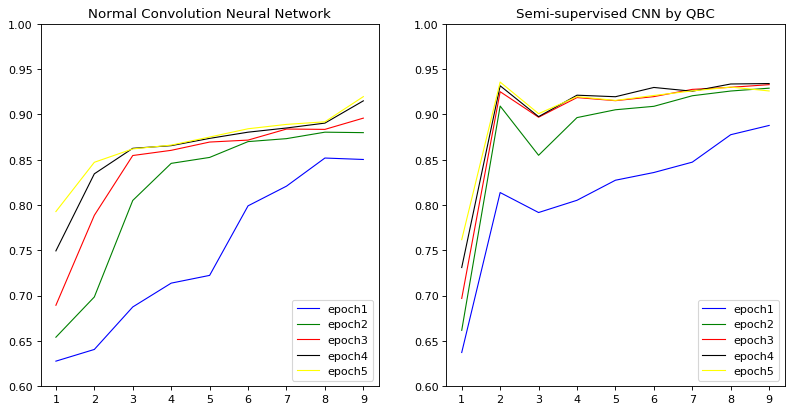

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6), dpi=80)
plt.subplot(1,2,1)
plt.title('Normal Convolution Neural Network')
plt.plot(range(1,10), cnn_result[:,0], color="blue", linewidth=1.0, linestyle="-", label="epoch1")
plt.plot(range(1,10), cnn_result[:,1], color="green", linewidth=1.0, linestyle="-", label="epoch2")
plt.plot(range(1,10), cnn_result[:,2], color="red", linewidth=1.0, linestyle="-", label="epoch3")
plt.plot(range(1,10), cnn_result[:,3], color="black", linewidth=1.0, linestyle="-", label="epoch4")
plt.plot(range(1,10), cnn_result[:,4], color="yellow", linewidth=1.0, linestyle="-", label="epoch5")
plt.ylim((0.6,1))
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.title('Semi-supervised CNN by QBC')
plt.plot(range(1,10), qbc_result[:9,0], color="blue", linewidth=1.0, linestyle="-", label="epoch1")
plt.plot(range(1,10), qbc_result[:9,1], color="green", linewidth=1.0, linestyle="-", label="epoch2")
plt.plot(range(1,10), qbc_result[:9,2], color="red", linewidth=1.0, linestyle="-", label="epoch3")
plt.plot(range(1,10), qbc_result[:9,3], color="black", linewidth=1.0, linestyle="-", label="epoch4")
plt.plot(range(1,10), qbc_result[:9,4], color="yellow", linewidth=1.0, linestyle="-", label="epoch5")
plt.ylim((0.6,1))
plt.legend(loc='lower right')

plt.show()

In [22]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import roc_auc_score
from keras.layers import Dropout

class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))


inp = Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = Embedding(num_words, EMBEDDING_DIM)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

x_train = data[:-num_validation_samples]
y_train = label['5'][:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = label['5'][-num_validation_samples:]


yt = labels[indices][:-num_validation_samples]
yv = np.array(labels[indices][-num_validation_samples:], dtype = float)

ra = RocAucEvaluation(validation_data=(x_val, yv), interval = 1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=1, verbose=1)

model.fit(x_train, yt,
          batch_size=128,
          epochs=5,
          callbacks = [ra, early_stopping],
          validation_data=(x_val, yv))

Train on 127657 samples, validate on 31914 samples
Epoch 1/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.1015 - acc: 0.9699
 ROC-AUC - epoch: 1 - score: 0.968838
127657/127657 [==============================] - 386s - loss: 0.1016 - acc: 0.9699 - val_loss: 0.0541 - val_acc: 0.9808
Epoch 2/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9817
 ROC-AUC - epoch: 2 - score: 0.971560
127657/127657 [==============================] - 384s - loss: 0.0516 - acc: 0.9817 - val_loss: 0.0514 - val_acc: 0.9816
Epoch 3/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0471 - acc: 0.9829
 ROC-AUC - epoch: 3 - score: 0.972797
127657/127657 [==============================] - 394s - loss: 0.0471 - acc: 0.9829 - val_loss: 0.0502 - val_acc: 0.9817
Epoch 4/5
127616/127657 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9839
 ROC-AUC - epoch: 4 - score: 0.973148
127657/127657 [==============================] - 383s

In [6]:
from keras.models import load_model
model = load_model('model_alllabel.h5')

I think the possibility of this sentence to be 
toxic is 0.503438830376, 
severe_toxic 0.00307771121152,         
obscene 0.0739611461759, 
threat 0.0122219342738, 
insult 0.156958609819, 
identity_hate 0.0310209169984


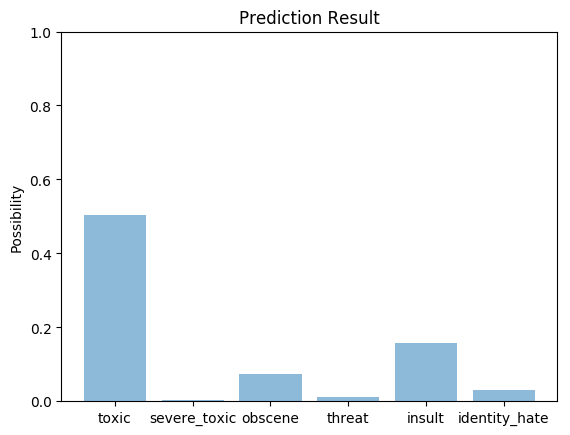

In [7]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

test1 = tokenizer.texts_to_sequences(["552 is a bad course"])
test2 = pad_sequences(test1, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict(test2)[0]

print 'I think the possibility of this sentence to be \ntoxic is {}, \nsevere_toxic {}, \
        \nobscene {}, \nthreat {}, \ninsult {}, \nidentity_hate {}'.format(pred[0], pred[1],\
                                                                  pred[2], pred[3], pred[4], pred[5])
 
objects = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate')
y_pos = np.arange(len(objects))
performance = pred
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylim(0,1)
plt.ylabel('Possibility')
plt.title('Prediction Result')
 
plt.show()